<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/autoML_h2o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Automatic Machine Learning (AutoML) with H20

In order for machine learning software to truly be accessible to non-experts, H2O have designed an easy-to-use interface which automates the process of training a large selection of candidate models. H2O's AutoML can also be a helpful tool for the advanced user, by providing a simple wrapper function that performs a large number of modeling-related tasks that would typically require many lines of code, and by freeing up their time to focus on other aspects of the data science pipeline tasks such as data-preprocessing, feature engineering and model deployment.

H2O's AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit.

H2O offers a number of model explainability methods that apply to AutoML objects (groups of models), as well as individual models (e.g. leader model). Explanations can be generated automatically with a single function call, providing a simple interface to exploring and explaining the AutoML models.

#### Install h2o, tidymodels and Metrics

In [1]:
install.packages("h2o")
install.packages("tidymodels")
install.packages("Metrics")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘RCurl’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘Rcpp’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘iterators’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘foreach’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Load Packages

In [14]:
library(tidyverse)
library(tidymodels)
library(Metrics)

#### Data

In [52]:
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data_syn.csv"
mf<-read_csv(url(urlfile))
#mf<-read_csv("/content/sample_data/gp_soil_data_syn.csv")
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, TPI,MAT, MAP,NDVI, NLCD, FRG)%>%
    glimpse()

Rows: 1408 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): NLCD, FRG
dbl (8): ID, SOC, DEM, Slope, TPI, MAP, MAT, NDVI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,408
Columns: 9
$ SOC   <dbl> 1.900, 2.644, 0.800, 0.736, 15.641, 8.818, 3.782, 6.641, 4.803, …
$ DEM   <dbl> 2825.1111, 2535.1086, 1716.3300, 1649.8933, 2675.3113, 2581.4839…
$ Slope <dbl> 18.981682, 14.182393, 1.585145, 9.399726, 12.569353, 6.358553, 1…
$ TPI   <dbl> -0.91606224, -0.15259802, -0.39078590, -2.54008722, 7.40076303, …
$ MAT   <dbl> 4.709227, 4.648000, 6.360833, 10.265385, 2.798550, 6.358550, 7.0…
$ MAP   <dbl> 613.6979, 597.7912, 201.5091, 298.2608, 827.4680, 679.1392, 508.…
$ NDVI  <dbl> 0.6845260, 0.7557631, 0.2215059, 0.2785148, 0.7337426, 0.7017139…
$ NLCD  <chr> "Forest", "Forest", "Shrubland", "Shrubland", "Forest", "Forest"…
$ FRG   <chr> "Fire Regime Group IV", "Fire Regime Group IV", "Fire Regime Gro…


### Data Preprocessing

#### Convert to factor

In [22]:
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)

#### Data Split

In [23]:
set.seed(1245)   # for reproducibility
split_01 <- initial_split(df, prop = 0.8, strata = SOC)
train <- split_01 %>% training()
test <-  split_01 %>% testing()

#### Data Scaling

In [24]:
train[-c(1, 8,9)] = scale(train[-c(1,8,9)])
test[-c(1, 8,9)] = scale(test[-c(1,8,9)])

### Import h20

In [25]:
library(h2o)
h2o.init()
#disable progress bar for RMarkdown
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 hours 57 minutes 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.40.0.4 
    H2O cluster version age:    2 months and 22 days 
    H2O cluster name:           H2O_started_from_R_root_yqz807 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.04 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 4.3.1 (2023-06-16) 



### Import data to h2o cluster

In [26]:
h_df=as.h2o(df)
h_train = as.h2o(train)
h_test = as.h2o(test)

In [27]:
train.xy<- as.data.frame(h_train)
test.xy<- as.data.frame(h_test)

#### Define response and predictors

In [28]:
y <- "SOC"
x <- setdiff(names(h_df), y)

#### AutoML: Automatic Machine Learning

The H2O AutoML interface is designed to have as few parameters as possible so that all the user needs to do is point to their dataset, identify the response column and optionally specify a time constraint or limit on the number of total models trained.

In both the R and Python API, AutoML uses the same data-related arguments, `x`, `y`, `training_frame`, `validation_frame`, as the other H2O algorithms. Most of the time, all you'll need to do is specify the data arguments. You can then configure values for `max_runtime_secs` and/or `max_models` to set explicit time or number-of-model limits on your run.

#### **Required Data Parameters**

-   [y](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/y.html): This argument is the name (or index) of the response column.

-   [training_frame](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/training_frame.html): Specifies the training set.

#### **Required Stopping Parameters**

One of the following stopping strategies (time or number-of-model based) must be specified. When both options are set, then the AutoML run will stop as soon as it hits one of either When both options are set, then the AutoML run will stop as soon as it hits either of these limits.

-   [max_runtime_secs](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/max_runtime_secs.html): This argument specifies the maximum time that the AutoML process will run for. The default is 0 (no limit), but dynamically sets to 1 hour if none of `max_runtime_secs` and `max_models` are specified by the user.

-   [max_models](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/max_models.html): Specify the maximum number of models to build in an AutoML run, excluding the Stacked Ensemble models. Defaults to `NULL/None`. Always set this parameter to ensure AutoML reproducibility: all models are then trained until convergence and none is constrained by a time budget.

In [30]:
df.aml <- h2o.automl(
                  x= x,
                  y = y,
                  training_frame = h_df,
                  nfolds=5,
                  keep_cross_validation_predictions = TRUE,
                  stopping_metric = "RMSE",
                  stopping_tolerance = 0.001,
                  stopping_rounds = 3,
                  max_runtime_secs_per_model = 1,
                  seed = 42,
                  max_models = 100,
                  project_name = "AutoML_trainings")
df.aml


00:50:25.849: Stopping tolerance set by the user is < 70% of the recommended default of 0.026650089544451302, so models may take a long time to converge or may not converge at all.
00:51:39.75: Stopping tolerance set by the user is < 70% of the recommended default of 0.026650089544451302, so models may take a long time to converge or may not converge at all.
00:51:39.76: New models will be added to existing leaderboard AutoML_trainings@@SOC (leaderboard frame=null) with already 2 models.

AutoML Details
Project Name: AutoML_trainings 
Leader Model ID: StackedEnsemble_BestOfFamily_1_AutoML_3_20230721_05139 
Algorithm: stackedensemble 

Total Number of Models Trained: 104 
Start Time: 2023-07-21 00:51:39 UTC 
End Time: 2023-07-21 00:57:13 UTC 
Duration: 334 s

Leaderboard
                                                 model_id     rmse      mse
1  StackedEnsemble_BestOfFamily_1_AutoML_3_20230721_05139 1.592658 2.536559
2     StackedEnsemble_AllModels_1_AutoML_3_20230721_05139 1.595023 2.544097
3          XGBoost_grid_1_AutoML_3_20230721_05139_model_2 1.631660 2.662315
4                           GBM_6_AutoML_3_20230721_05139 1.639635 2.688404
5                           GBM_5_AutoML_3_20230721_05139 1.651592 2.727757
6                       XGBoost_4_AutoML_3_20230721_05139 1.656736 2.744773
7          XGBoost_grid_1_AutoML_3_20230721_05139_model_1 1.662426 2.763660
8                           GBM_4_AutoML_3_20230721_05139 1.663405 2.766916
9                           G

###   Leaderboard

In [39]:
lb <- h2o.get_leaderboard(object = df.aml, extra_columns = "ALL")
head(lb)


,model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,StackedEnsemble_BestOfFamily_1_AutoML_3_20230721_05139,1.592658,2.536559,0.6796475,0.2539381,2.536559,880,0.096140,StackedEnsemble
2,StackedEnsemble_AllModels_1_AutoML_3_20230721_05139,1.595023,2.544097,0.6811646,0.2473979,2.544097,3138,0.339030,StackedEnsemble
3,XGBoost_grid_1_AutoML_3_20230721_05139_model_2,1.631660,2.662315,0.6659603,0.2637889,2.662315,176,0.006793,XGBoost
4,GBM_6_AutoML_3_20230721_05139,1.639635,2.688404,0.6956456,0.2591596,2.688404,1091,0.089640,GBM
5,GBM_5_AutoML_3_20230721_05139,1.651592,2.727757,0.7193337,0.2624052,2.727757,1717,0.124135,GBM
6,XGBoost_4_AutoML_3_20230721_05139,1.656736,2.744773,0.7046530,0.2615207,2.744773,933,0.015534,XGBoost


### The best model

In [40]:
best_ML<- h2o.get_best_model(df.aml, criterion = "RMSE" )
best_ML

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  StackedEnsemble_BestOfFamily_1_AutoML_3_20230721_05139 
Model Summary for Stacked Ensemble: 
                                         key            value
1                          Stacking strategy cross_validation
2       Number of base models (used / total)              4/6
3           # GBM base models (used / total)              1/1
4       # XGBoost base models (used / total)              1/1
5           # DRF base models (used / total)              1/2
6  # DeepLearning base models (used / total)              0/1
7           # GLM base models (used / total)              1/1
8                      Metalearner algorithm              GLM
9         Metalearner fold assignment scheme           Random
10                        Metalearner nfolds                5
11                   Metalearner fold_column               NA
12        Custom metalearner hyperparameters             None


H2ORegressionMetrics: stackedensembl

### Prediction

In [45]:
best.test<-as.data.frame(h2o.predict(object = best_ML, newdata = h_test))
test.xy$Pred_SOC<-best.test$predict

In [50]:
RMSE<- Metrics::rmse(test.xy$SOC, test.xy$Pred_SOC)
MAE<- Metrics::mae(test.xy$SOC, test.xy$Pred_SOC)

# Print results
paste0("RMSE: ", round(RMSE,2))
paste0("MAE: ", round(MAE,2))


[1] "RMSE: 4.26"

[1] "MAE: 3.03"

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


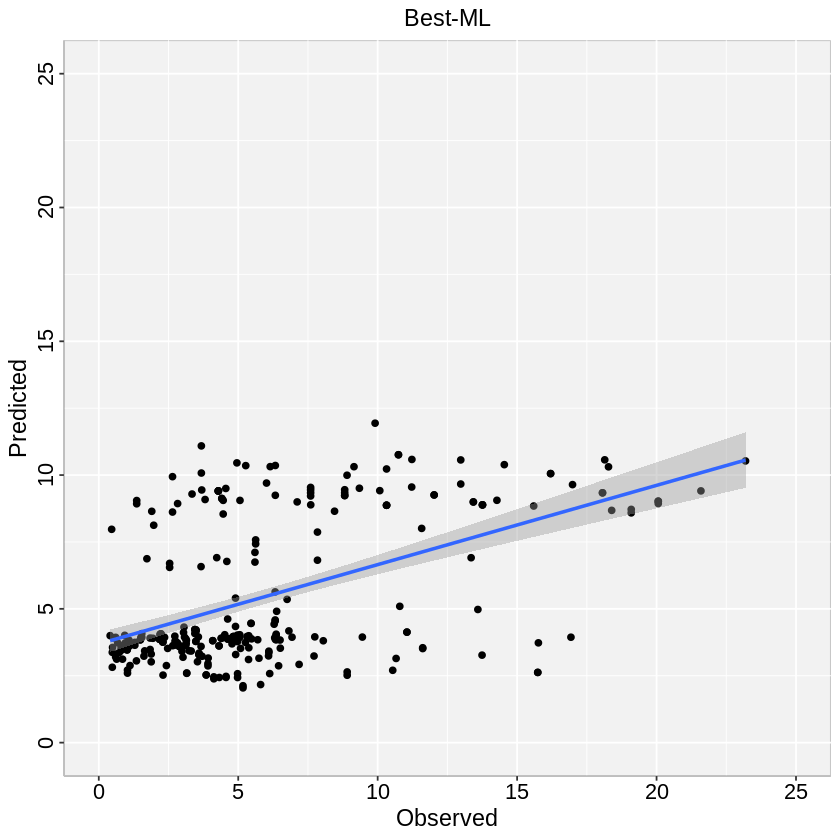

In [51]:

ggplot(test.xy, aes(SOC,Pred_SOC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  ggtitle("Best-ML") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))